# RVC Exploratory Data Analysis

**Last Modified**: Aug 20, 2025

In this notebook, we calibrate the RVC historic data and apply a prediction model trained on summarized Vectronics data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import os
import sys
from itertools import combinations
import yaml
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull
from itertools import combinations
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

from scripts.run_RVC_preprocessing import (load_RVC_data,
                                           load_RVC_metadata,)

from src.utils.functionalities import (median_pairwise_distance,
                                       mmd_test)
from src.utils.RVC_preprocessing import preprocess_data
import config as config
import src.utils.io as io
from src.utils.plots import (plot_scores)
from src.utils.functionalities import (compute_mmd,
                                       median_pairwise_distance)

In [3]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

## 1. Data Cleaning and Exploratory Data Analysis

In [6]:
# Load RVC config
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)

RVC_feature_cols = RVC_preprocessing_config['feature_cols']
RVC_helper_cols = RVC_preprocessing_config['helper_cols']

In [8]:
df = load_RVC_data(data_dir=config.HISTORIC_ACC_ANNOTATED)
metadata_df = load_RVC_metadata()

df_summary = df.groupby('animal_id').agg({'UTC date [yyyy-mm-dd]': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary


,Start date,End date,Total no. of windows,No. of unique dates
animal_id,,,,
Accra,2012-04-19,2012-08-29,16859,22
Adiga,2013-08-07,2016-03-22,1032286,591
Aztec,1970-01-01,2014-10-01,233280,227
Bali,2015-01-31,2016-03-04,715608,371
Bobedi,1970-01-01,2012-06-22,110643,130
Bongwe,2012-04-11,2016-02-05,486130,272
Brian,1970-01-04,2012-05-31,24424,28
Dar,2012-04-15,2012-05-05,18087,21
Fiji,2016-03-23,2016-11-23,463662,246


In [6]:
from src.utils.RVC_preprocessing import (remove_duplicates,
                                         calibrate_RVC_data,
                                         )

df = remove_duplicates(df)

# Calibration
calibrated_df = calibrate_RVC_data(df, metadata_df)

Removed 72191 duplicates.


/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.29019608 0.03921569 0.04705882 ... 0.21176471 0.21960784 1.18431373]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'acc_x_ptp_max'] = df.loc[mask, 'acc_x_ptp_max'].astype(float) / sensitivity_X
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:277: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.12096774 0.02419355 0.03225806 ... 0.38709677 0.33870968 0.83870968]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'acc_y_ptp_max'] = df.loc[mask, 'acc_y_ptp_max'].astype(float) / sensitivity_Y
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:278: FutureWarning: 

No data found for animal_id Augustus in the date range NaT to NaT
No data found for animal_id Bali in the date range 2013-12-23 00:00:00 to 2014-09-17 00:00:00
No data found for animal_id MJ in the date range NaT to NaT
No data found for animal_id Scorpion in the date range 2012-10-08 00:00:00 to 2012-10-30 00:00:00
No data found for animal_id Scorpion in the date range 2012-11-02 00:00:00 to 2013-10-05 00:00:00
No data found for animal_id Seronera in the date range NaT to NaT
No data found for animal_id Yolo in the date range 2012-09-21 00:00:00 to 2012-10-23 00:00:00
No data found for animal_id Gobi in the date range NaT to NaT
Number of rows without calibration metadata: 53698/7177165


Feature: acc_x_ptp_max, number of outliers: 3586
Feature: acc_y_ptp_max, number of outliers: 273
Feature: acc_z_ptp_max, number of outliers: 28
Feature: acc_x_ptp_mean, number of outliers: 15
Feature: acc_y_ptp_mean, number of outliers: 18
Feature: acc_z_ptp_mean, number of outliers: 25
Feature: acc_x_mean, number of outliers: 42327
Feature: acc_y_mean, number of outliers: 42322
Feature: acc_z_mean, number of outliers: 42345


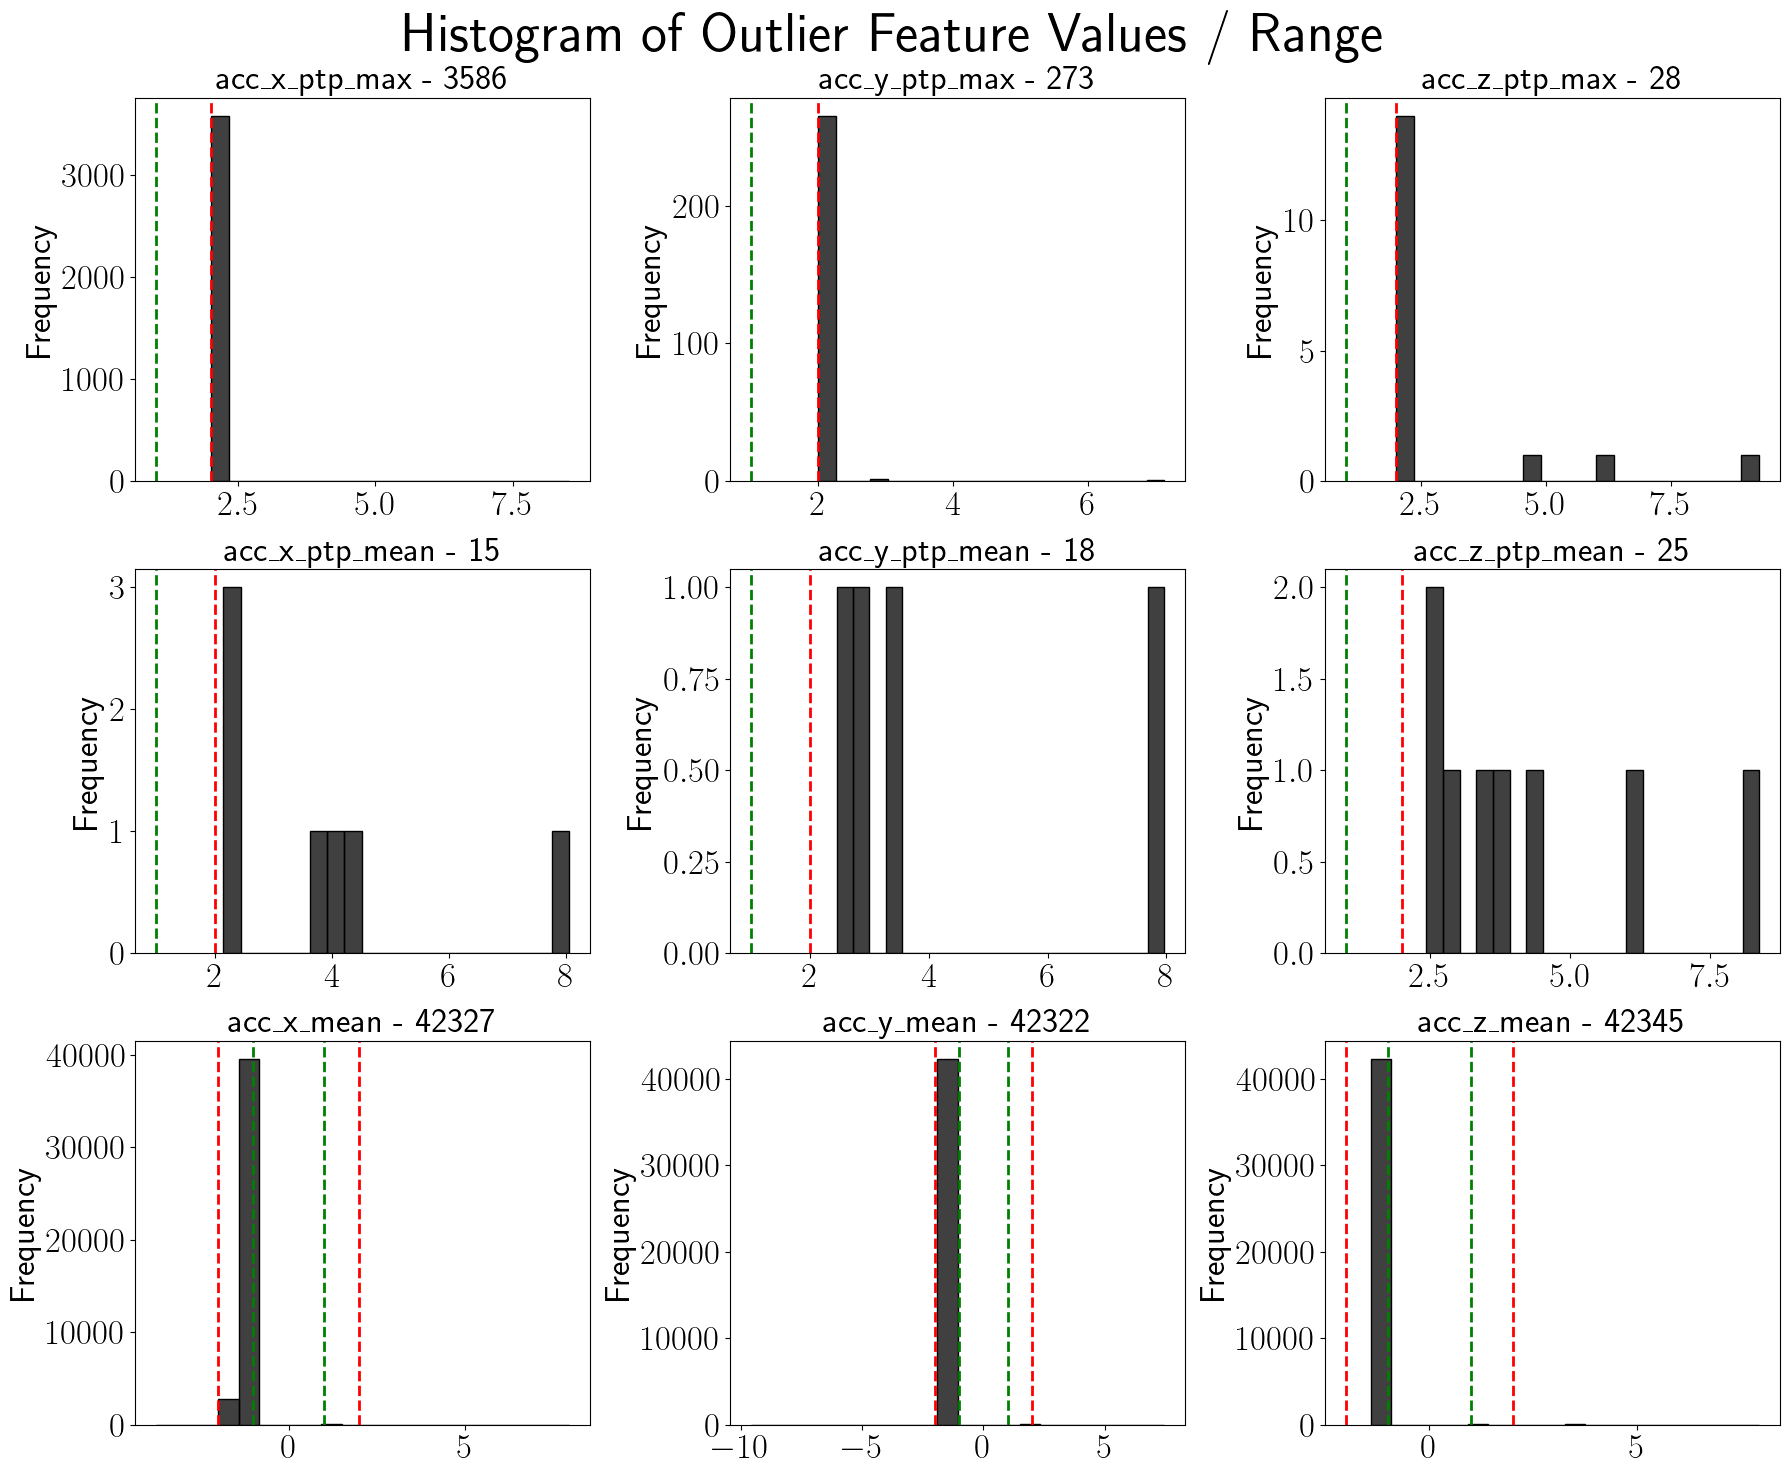

In [31]:
ncols=3
nrows = int(np.ceil(len(RVC_feature_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axs = axes.flatten()

for i, col in enumerate(RVC_feature_cols):
    if 'ptp' in col:
        outliers = calibrated_df[(calibrated_df[col] < 0) | (calibrated_df[col] > 2*calibrated_df['range'])]
        print(f"Feature: {col}, number of outliers: {len(outliers)}")
        outlier_vals = outliers[col]/outliers['range']
        outlier_vals = outlier_vals[outlier_vals <= 10]
        axs[i].axvline(x=1.0, linestyle='--', color='green', linewidth=2)
        axs[i].axvline(x=2.0, linestyle='--', color='red', linewidth=2)



    else:
        outliers = calibrated_df[(calibrated_df[col] < -calibrated_df['range']) | (calibrated_df[col] > calibrated_df['range'])]
        print(f"Feature: {col}, number of outliers: {len(outliers)}")
        outlier_vals = outliers[col]/outliers['range']
        outlier_vals = outlier_vals[(outlier_vals >= -10) & (outlier_vals <= 10)]
        axs[i].axvline(x=1.0, linestyle='--', color='green', linewidth=2)
        axs[i].axvline(x=-1.0, linestyle='--', color='green', linewidth=2)
        axs[i].axvline(x=-2.0, linestyle='--', color='red', linewidth=2)
        axs[i].axvline(x=2.0, linestyle='--', color='red', linewidth=2)

    sns.histplot(
                outlier_vals,
                kde=False,
                ax=axs[i],
                bins=20,
                color='black'
            )

    axs[i].set_title(f"{col} - {(len(outliers))}")
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('')
    # axs[i].set_yscale("log")

fig.suptitle("Histogram of Outlier Feature Values / Range", fontsize=40)
plt.tight_layout()
plt.show()

In [6]:
# load and preprocess RVC data

if os.path.exists(io.get_RVC_preprocessed_path()):
    RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
else:
    RVC_df = preprocess_data(
            df=df,
            metadata_df=metadata_df,
            feature_cols=RVC_preprocessing_config['feature_cols'],
            helper_cols=RVC_preprocessing_config['helper_cols'],
            summary_dir=io.get_results_dir()
        )

In [36]:
cols = ['feeding_binary', 'moving_binary', 'resting_binary']
RVC_df[cols] = RVC_df[cols].fillna(0)
mask = RVC_df[cols].eq(1).any(axis=1)
rows_with_1 = RVC_df[mask]   # optional: get the actual rows
num_rows_with_1 = mask.sum()
print(f"{np.round(num_rows_with_1/len(RVC_df)*100, 2)}% of the data is labelled")

84.42% of the data is labelled


In [37]:
RVC_df['behavior'] = np.select(
    [
        RVC_df['feeding_binary'] == 1,
        RVC_df['moving_binary'] == 1,
        RVC_df['resting_binary'] == 1
    ],
    ['Feeding', 'Moving', 'Resting'],
    default=None  # or "Unknown"
)

In [ ]:
# Load preprocessed Vectronics config

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)

Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']
Vectronics_helper_cols = Vectronics_preprocessing_config['helper_cols']
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(duration=15.0))
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

In [ ]:
groups = {}
for name, g in RVC_df.groupby(['firmware_major_version', 'animal_id', 'collar_number']):
    arr = g[RVC_feature_cols].sample(frac=1, random_state=42).head(2000).values  # shuffle + take first 1000
    groups[name] = arr
    print(f"Group {name} with {arr.shape[0]} samples.")

group_keys = list(groups.keys())
n_groups = len(group_keys)
mmd_matrix = np.zeros((n_groups, n_groups))

for i, j in tqdm(combinations(range(n_groups), 2)):
    X = groups[group_keys[i]]
    Y = groups[group_keys[j]]
    sigma = median_pairwise_distance(X, Y)
    dist = compute_mmd(X, Y, sigma=sigma)
    mmd_matrix[i, j] = dist
    mmd_matrix[j, i] = dist

In [10]:
mmd_df = pd.DataFrame(mmd_matrix, index=group_keys, columns=group_keys)
group_info = pd.DataFrame(list(mmd_df.index), columns=["animal_id", "collar_number", "firmware_major_version"])

group_info["key"] = list(mmd_df.index)

# Sort by firmware
sorted_keys = group_info.sort_values(["firmware_major_version", "collar_number"])["key"]
mmd_df_sorted = mmd_df.loc[sorted_keys, sorted_keys]

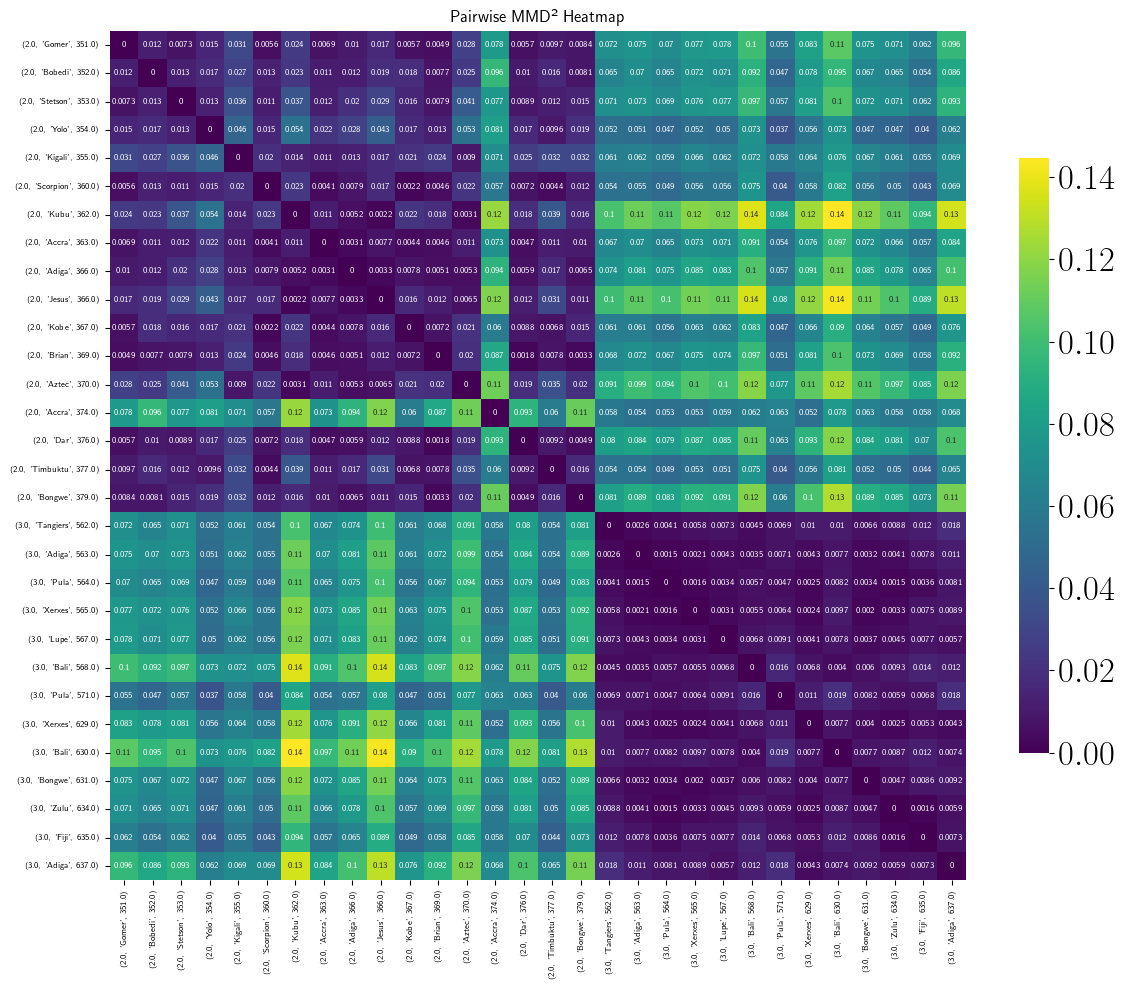

In [11]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    mmd_df_sorted, 
    annot=True, 
    cmap="viridis", 
    annot_kws={"size": 6},   # smaller annotation text
    cbar_kws={"shrink": 0.7}
)

# Force all tick labels to show
ax.set_xticks(np.arange(len(mmd_df_sorted)) + 0.5)
ax.set_yticks(np.arange(len(mmd_df_sorted)) + 0.5)
ax.set_xticklabels(mmd_df_sorted.columns, rotation=90, fontsize=6)
ax.set_yticklabels(mmd_df_sorted.index, fontsize=6)

plt.title("Pairwise MMD² Heatmap", fontsize=12)
plt.tight_layout()
plt.show()

In [23]:
groups = {}
for name, g in vectronics_df.groupby('animal_id'):
    arr = g[Vectronics_feature_cols].sample(frac=1, random_state=42).head(5000).values  # shuffle + take first 1000
    groups[name] = arr
    print(f"Group {name} with {arr.shape[0]} samples.")
group_keys = list(groups.keys())
n_groups = len(group_keys)
mmd_matrix = np.zeros((n_groups, n_groups))

for i, j in tqdm(combinations(range(n_groups), 2)):
    X = groups[group_keys[i]]
    Y = groups[group_keys[j]]
    sigma = median_pairwise_distance(X, Y)
    dist = compute_mmd(X, Y, sigma=sigma)
    mmd_matrix[i, j] = dist
    mmd_matrix[j, i] = dist

Group ash with 1558 samples.
Group fossey with 935 samples.
Group green with 1929 samples.
Group jessie with 2838 samples.
Group palus with 383 samples.


10it [00:02,  4.62it/s]


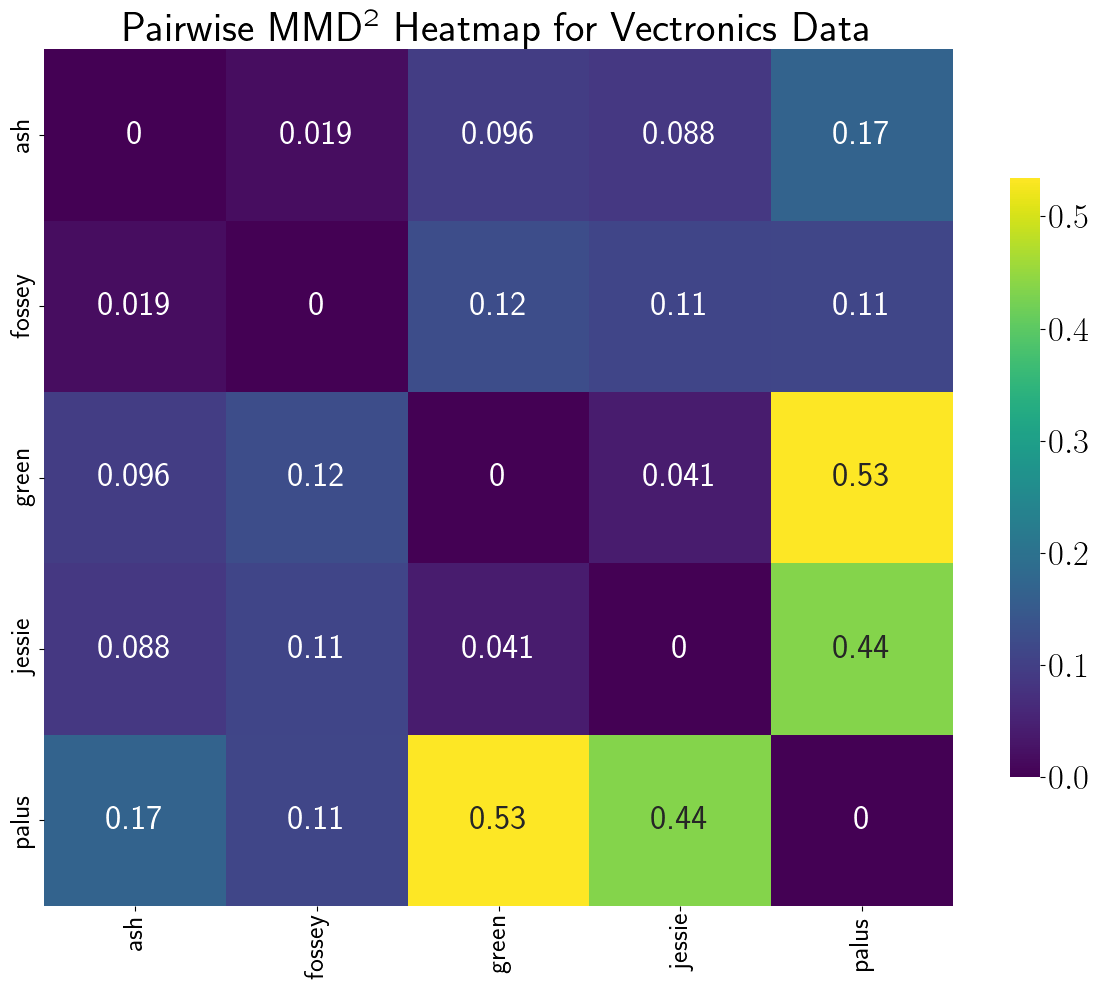

In [24]:
mmd_df = pd.DataFrame(mmd_matrix, index=group_keys, columns=group_keys)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    mmd_df, 
    annot=True, 
    cmap="viridis", 
    annot_kws={"size": 25},   # smaller annotation text
    cbar_kws={"shrink": 0.7}
)

# Force all tick labels to show
ax.set_xticks(np.arange(len(mmd_df)) + 0.5)
ax.set_yticks(np.arange(len(mmd_df)) + 0.5)
ax.set_xticklabels(mmd_df.columns, rotation=90, fontsize=20)
ax.set_yticklabels(mmd_df.index, fontsize=20)

plt.title("Pairwise MMD² Heatmap for Vectronics Data", fontsize=30)
plt.tight_layout()
plt.show()

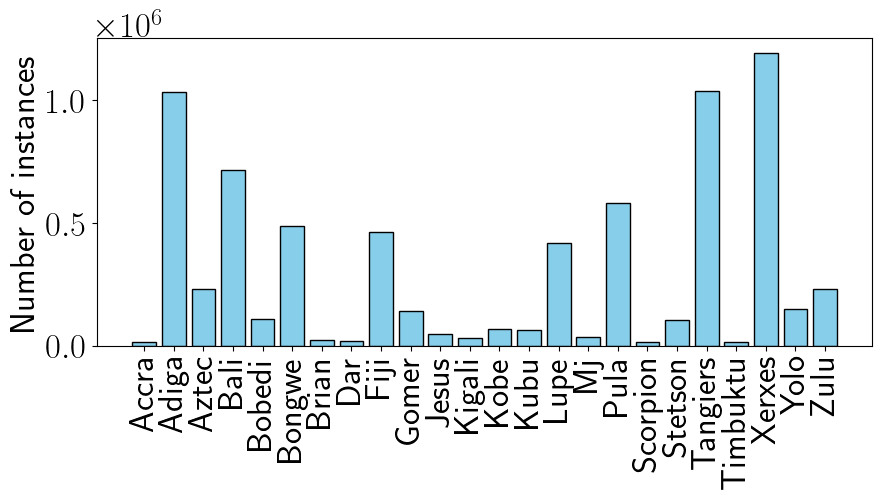

In [ ]:
plt.figure(figsize = (10,4))
plt.bar(df_summary.index, df_summary['Total no. of windows'], color='skyblue', edgecolor='black')
plt.ylabel('Number of instances')
plt.xticks(rotation = 90)
plt.show()

Notice the presence of outliers for several dogs, especially Bongwe.

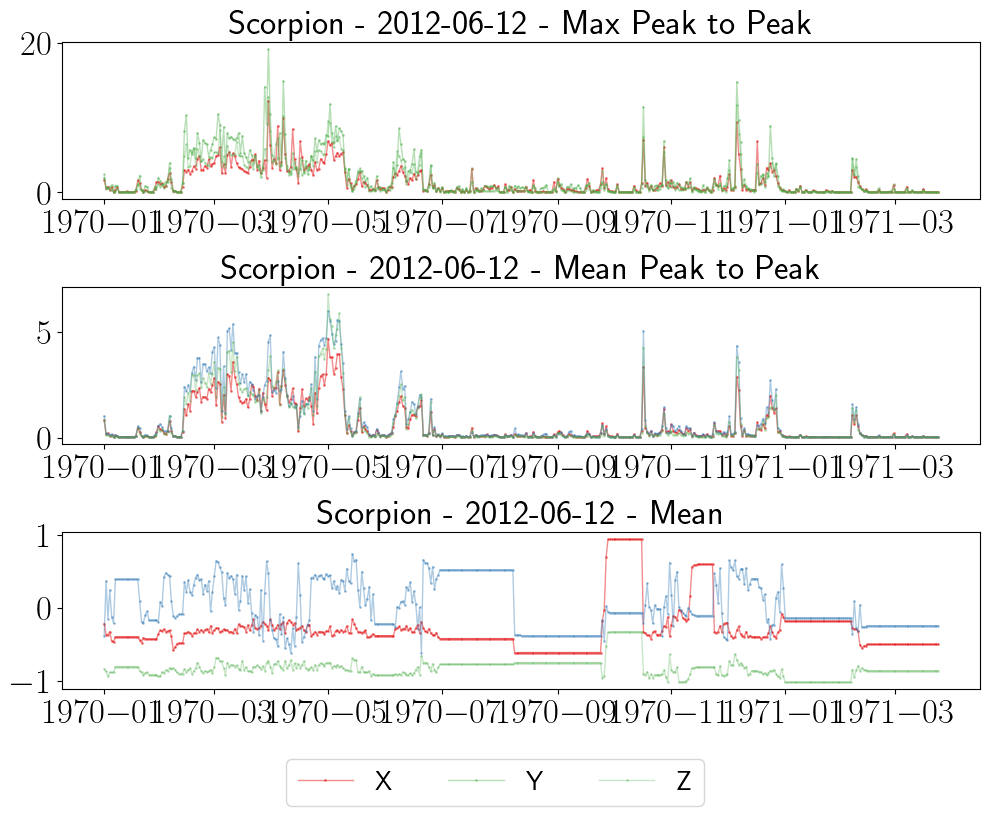

In [8]:
dogs = RVC_df.animal_id.unique()
selected_dog = np.random.choice(dogs)
df_sub = RVC_df[RVC_df.animal_id == selected_dog]
dates = df_sub['UTC date [yyyy-mm-dd]'].unique()
date = np.random.choice(dates)

palette = sns.color_palette("Set1", n_colors=3)

fig, axs = plt.subplots(3, 1, figsize=(10,7.5))

df_tmp = df_sub[df_sub['UTC date [yyyy-mm-dd]'] == date]
loc = AutoDateLocator()
form = AutoDateFormatter(loc)
axs[0].xaxis.set_major_locator(loc)
axs[0].xaxis.set_major_formatter(form)  
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_max'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='X')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_max'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[2], label='Y')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_max'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Z')
axs[0].set_title(f'{selected_dog} - {str(date)} - Max Peak to Peak')
# axs[0].legend(loc='best')

axs[1].xaxis.set_major_locator(loc)
axs[1].xaxis.set_major_formatter(form)  
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[1].set_title(f'{selected_dog} - {str(date)} - Mean Peak to Peak')
# axs[1].legend(loc='best')

axs[2].xaxis.set_major_locator(loc)
axs[2].xaxis.set_major_formatter(form)  
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[2].set_title(f'{selected_dog} - {str(date)} - Mean')
# axs[2].legend(loc='best')

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
plt.tight_layout()
plt.show()

In [27]:
summary1 = vectronics_df[Vectronics_feature_cols].agg(['min', 'max']).T
summary2 = (
    RVC_df
    .groupby(['animal_id', 'collar_number', 'firmware_major_version'])[Vectronics_feature_cols]
    .agg(['min', 'max'])
    .reset_index()   # <-- makes animal_id and collar_number normal columns
)

summary2.to_csv("summary2.csv", index=False)# Save to CSV


summary1 = vectronics_df[Vectronics_feature_cols].agg(['min', 'max']).T
summary2 = RVC_df[Vectronics_feature_cols].agg(['min', 'max']).T
summary1 = summary1.rename(columns={'min': 'Vectronics min', 'max': 'Vectronics max'})
summary2 = summary2.rename(columns={'min': 'RVC min', 'max': 'RVC max'})

merged_summary = pd.concat([summary1, summary2], axis=1, keys=['Vectronics', 'RVC'])
print(merged_summary)

                   Vectronics                      RVC           
               Vectronics min Vectronics max   RVC min    RVC max
acc_x_ptp_max        0.000000      13.010000  0.000000  22.191235
acc_y_ptp_max        0.000000      13.440000  0.000000  22.900826
acc_z_ptp_max        0.000000      10.630000  0.000000  21.791165
acc_x_ptp_mean       0.000000       9.366667  0.000000  14.766798
acc_y_ptp_mean       0.000000       5.424000  0.000000  20.281250
acc_z_ptp_mean       0.000000       7.564000  0.000000  15.951807
acc_x_mean          -0.579792       1.044563 -3.385294   6.176070
acc_y_mean          -0.995875       1.060000 -4.655754   7.067061
acc_z_mean          -0.880000       1.253583 -7.967118   7.997047


In [8]:
from src.utils import preprocess

X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values,
            RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values]

In [9]:
# shuffle the rows 
np.random.shuffle(X_src)
print(f"Number of samples in source data: {X_src.shape[0]}")

for Xt in X_targets:
    np.random.shuffle(Xt)
    print(f"Number of samples in target data: {Xt.shape[0]}")

Number of samples in source data: 9099
Number of samples in target data: 1252217
Number of samples in target data: 5824909


/tmp/ipykernel_2257337/2242985945.py:49: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


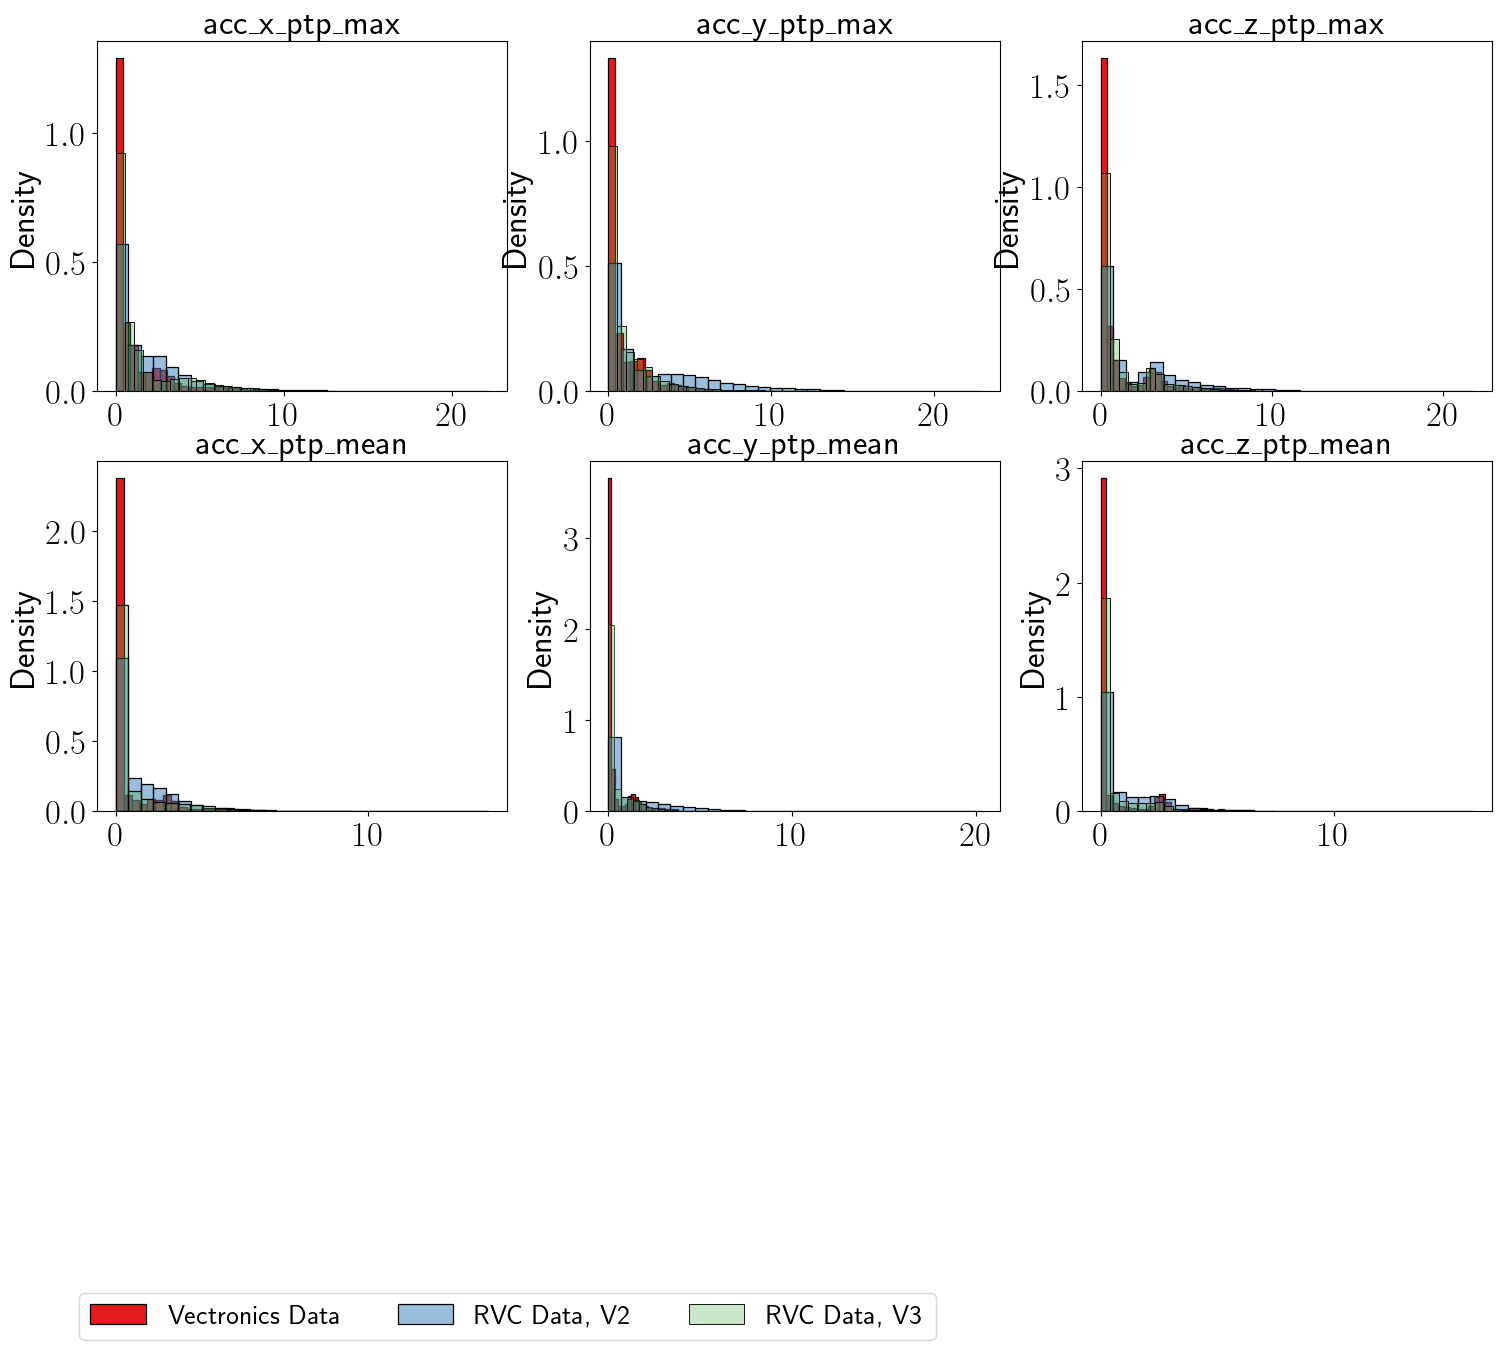

In [17]:
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(
                X_targets[0][:,i],
                kde=False,
                label='RVC Data, V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        
        sns.histplot(
                X_targets[1][:,i],
                kde=False,
                label='RVC Data, V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.3
            )

        ax.set_title(col)
        ax.set_ylabel('Density')
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(1.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


## 2. Determine Covariate Shift

We compute the sliced Wasserstein distance and Sinkhorn divergence between the two datasets with increasing number of samples $n$ to check if the computed distance decreases as a function of $n$.

#### 4.1 Between train and test data

In [ ]:
n, m = 2000, 2000

print("Comparing Vectronics Data with RVC Data, Firmware V2")
sigma = median_pairwise_distance(X_src[:n, :], X_targets[0][:m, :])
stat, permuted_stat, pval = mmd_test(X=X_src[:n, :], Y= X_targets[0][:m, :], sigma=sigma, num_permutations=100, seed=42)
print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.8f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.8f} - The two distributions are not significantly different (fail to reject H0).")

print("Comparing Vectronics Data with RVC Data, Firmware V3")
sigma = median_pairwise_distance(X_src[:n, :], X_targets[1][:m, :])
stat, permuted_stat, pval = mmd_test(X=X_src[:n, :], Y= X_targets[1][:m, :], sigma=sigma, num_permutations=100, seed=42)
print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.8f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.8f} - The two distributions are not significantly different (fail to reject H0).")


Comparing Vectronics Data with RVC Data, Firmware V2
MMD^2 statistic: 0.0798
P-value: 0.0000 - The two distributions are significantly different (reject H0).
Comparing Vectronics Data with RVC Data, Firmware V3
MMD^2 statistic: 0.0569
P-value: 0.0000 - The two distributions are significantly different (reject H0).


#### 4.2 Between two versions of test data

In [31]:
n, m = 2000, 2000
sigma = median_pairwise_distance(X_targets[0][:n, :], X_targets[1][:m, :])
stat, permuted_stat, pval = mmd_test(X=X_targets[0][:n, :], Y=X_targets[1][:m, :], sigma=sigma, num_permutations=100, seed=42)

print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.8f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.8f} - The two distributions are not significantly different (fail to reject H0).")

MMD^2 statistic: 0.0717
P-value: 0.00000000 - The two distributions are significantly different (reject H0).


## 3. Determine Overlap

In [10]:

# ---------------------------------------------------------
# Univariate overlap diagnostics (per feature)
# ---------------------------------------------------------
def feature_overlap(x_train, x_test, feature_name=None):
    """
    Plots histograms and computes simple support overlap statistics.
    """
    min_train, max_train = np.round(x_train.min(), 4), np.round(x_train.max(), 4)
    min_test, max_test = np.round(x_test.min(), 4), np.round(x_test.max(), 4)

    # Overlap length / union length ratio
    overlap_min = np.round(max(min_train, min_test), 4)
    overlap_max = np.round(min(max_train, max_test), 4)
    overlap_range = np.round(max(0, overlap_max - overlap_min), 4)
    union_range = np.round(max(max_train, max_test) - min(min_train, min_test), 4)
    overlap_ratio = overlap_range / union_range if union_range > 0 else 0
    
    # Fraction of test samples outside train range
    frac_outside = np.mean((x_test < min_train) | (x_test > max_train))
    
    return {
        "feature": feature_name,
        "train_range": (min_train, max_train),
        "test_range": (min_test, max_test),
        "overlap_ratio": np.round(overlap_ratio, 4),
        "frac_test_outside_train": np.round(frac_outside, 4)
    }

# ---------------------------------------------------------
# Multivariate overlap diagnostics
# ---------------------------------------------------------
def multivariate_overlap_score_fast(X_train, X_test, bandwidth=1.0, n_sample=5000, random_state=0):
    """
    Approximate multivariate overlap using KDE on random subsamples.
    Significantly faster for large datasets.
    """
    rng = np.random.default_rng(random_state)
    X_train_sub = X_train[rng.choice(len(X_train), min(len(X_train), n_sample), replace=False)]
    X_test_sub  = X_test[rng.choice(len(X_test), min(len(X_test), n_sample), replace=False)]
    
    kde_train = KernelDensity(bandwidth=bandwidth).fit(X_train_sub)
    kde_test = KernelDensity(bandwidth=bandwidth).fit(X_test_sub)
    
    # Evaluate densities on smaller sample of target points
    X_eval = X_test_sub[rng.choice(len(X_test_sub), min(1000, len(X_test_sub)), replace=False)]
    log_p_train = kde_train.score_samples(X_eval)
    log_p_test  = kde_test.score_samples(X_eval)
    
    p_train = np.exp(log_p_train)
    p_test  = np.exp(log_p_test)
    overlap = np.mean(np.minimum(p_train, p_test)) / np.mean(p_test)
    return overlap

for i, target in enumerate(X_targets):
    print(f"TARGET {i+1} - Number of samples: {target.shape[0]}")
    # Run per feature
    stats = []
    for j in range(X_src.shape[1]):
        stats.append(feature_overlap(X_src[:, j], X_targets[i][:, j], feature_name=f"Feature {j+1}"))

    stats_df = pd.DataFrame(stats)
    print("\n=== Univariate Overlap Summary ===")
    print(stats_df)

    overlap_fast = multivariate_overlap_score_fast(X_src, X_targets[i], bandwidth=1.0)
    print(f"Approx. multivariate overlap (subsampled KDE): {overlap_fast:.3f}")



TARGET 1 - Number of samples: 1252217

=== Univariate Overlap Summary ===
     feature    train_range         test_range  overlap_ratio  \
0  Feature 1   (0.0, 13.01)  (0.0153, 22.1912)         0.5856   
1  Feature 2   (0.0, 13.44)  (0.0156, 22.9008)         0.5862   
2  Feature 3   (0.0, 10.63)  (0.0153, 21.7912)         0.4871   
3  Feature 4  (0.0, 9.3667)  (0.0076, 14.7668)         0.6338   
4  Feature 5   (0.0, 5.424)  (0.0078, 20.2812)         0.2671   
5  Feature 6   (0.0, 7.564)  (0.0077, 15.9518)         0.4737   

   frac_test_outside_train  
0                   0.0087  
1                   0.0169  
2                   0.0121  
3                   0.0005  
4                   0.0511  
5                   0.0087  
Approx. multivariate overlap (subsampled KDE): 0.957
TARGET 2 - Number of samples: 5824909

=== Univariate Overlap Summary ===
     feature    train_range      test_range  overlap_ratio  \
0  Feature 1   (0.0, 13.01)     (0.0, 16.0)         0.8131   
1  Feature 2   (

## 3. Transformations

Now we apply some preprocessing trasnformations on the featurees per deployment. The entire Vectronics dataset is considered on deployment. The RVC dataset is split into version 2 and version 3 sensor deployments that have different calibrations. For peak-to-peak features, we use the ``np.log1p`` trasnformations $T(x) = \log (1+x)$.

In [16]:
import torch

pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = None #[6, 7, 8]  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=pos_idx,
    center_idx=center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

X_src = transform(torch.tensor(X_src, dtype=torch.float32))
X_targets = [transform(torch.tensor(Xt, dtype=torch.float32)) for Xt in X_targets]

X_src = X_src.detach().numpy()
X_targets = [Xt.detach().numpy() for Xt in X_targets]

/tmp/ipykernel_2273831/2882906507.py:49: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


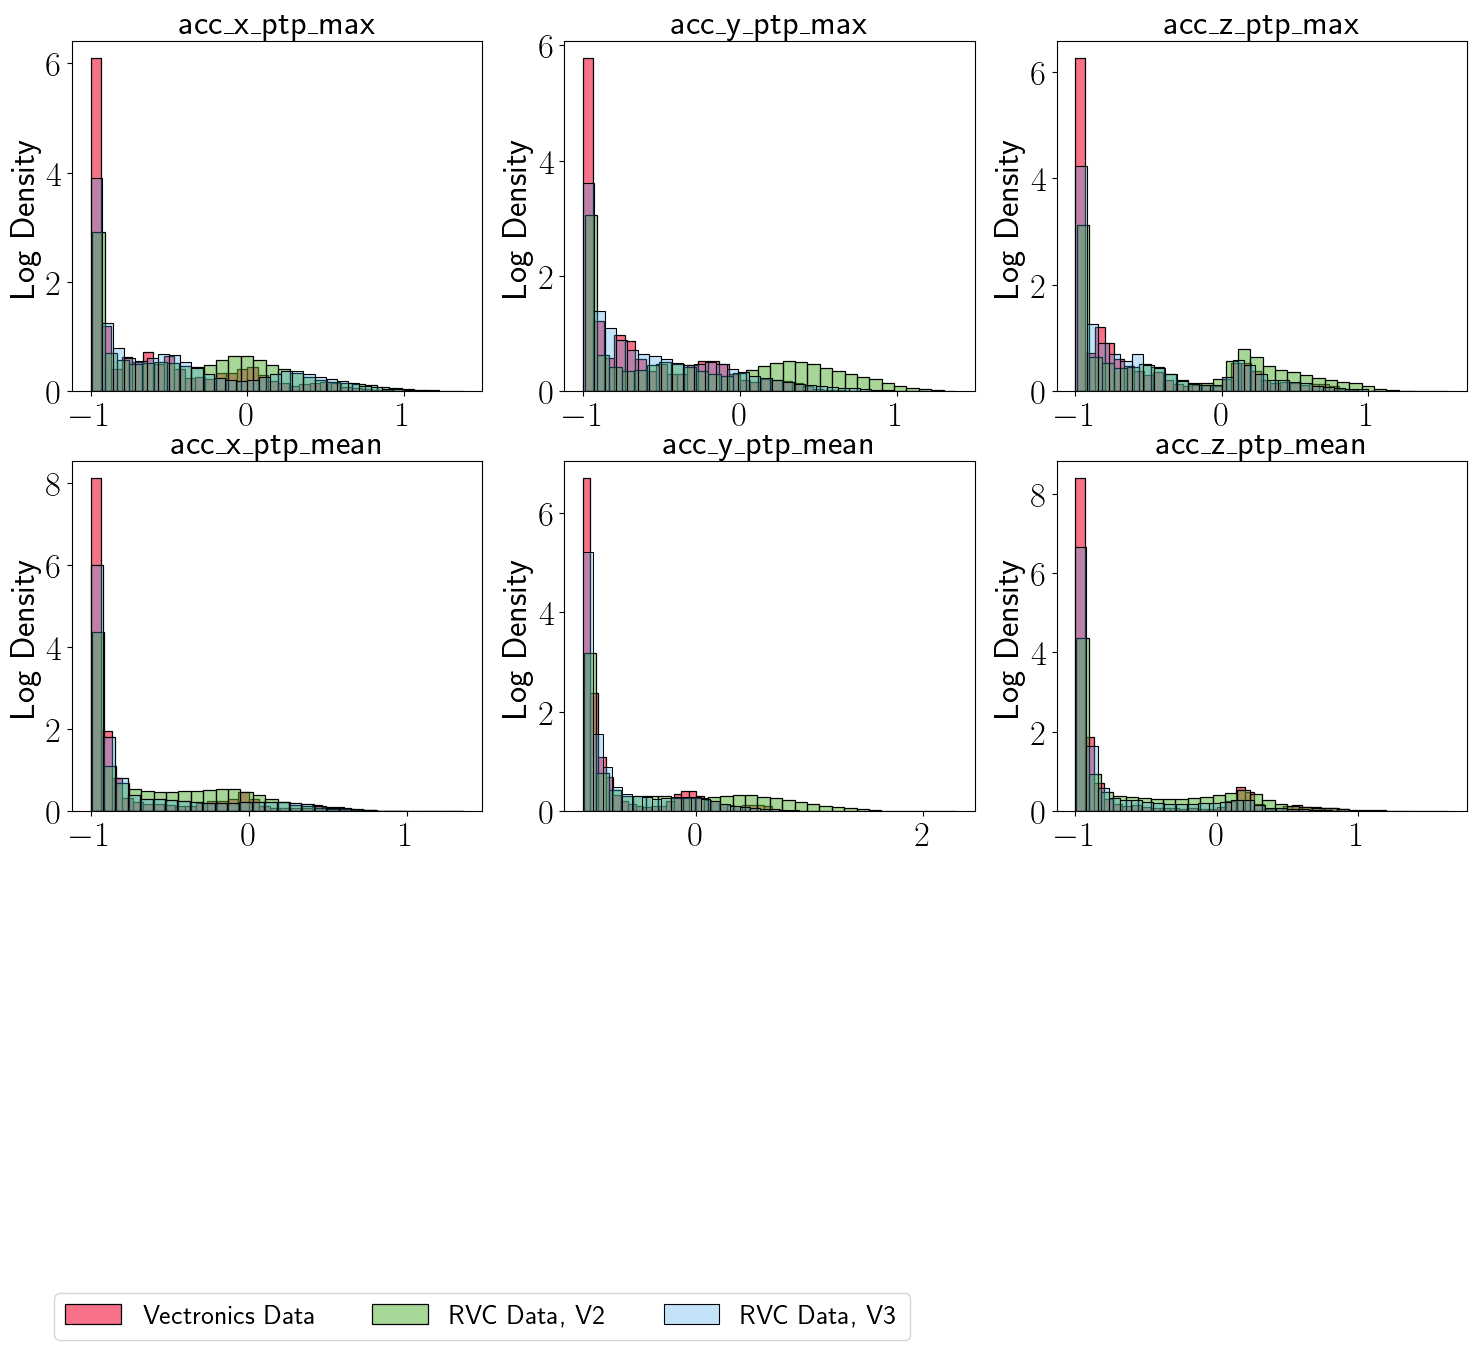

In [19]:
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("husl", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:, i],
                kde=False,
                label=f'Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i],
                kde=False,
                label='RVC Data, V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        
        sns.histplot(
                X_targets[1][:,i],
                kde=False,
                label='RVC Data, V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.3
            )

        ax.set_title(col)
        ax.set_ylabel('Log Density')
        # ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(1.0, -2.75), ncol=4)

plt.tight_layout()
plt.show()


## 5. Apply the Prediction Model

In [34]:
import torch
device = torch.device(f"cuda:{1}" if torch.cuda.is_available() else "cpu")
training_results_dir = os.path.join(io.get_results_dir(), 'summary_training_results')
theta, seed = 0.2, 1
model_dir = os.path.join(training_results_dir, f"theta{theta}_seed{seed}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [35]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

LabelEncoder()

In [67]:
# with torch.no_grad():
#     y_scores = model(torch.tensor(np.vstack(X_targets), dtype=torch.float32).to(device))

# y_scores = y_scores.cpu().numpy()
# y_pred = np.argmax(y_scores, axis=1)
# RVC_df['behavior'] = label_encoder.inverse_transform(y_pred)
# eating_events = RVC_df[RVC_df.behavior == 'Feeding']
# eating_events.to_csv(os.path.join(config.RVC_BEHAVIOR_EVAL_PATH, 'eating_events.csv'), index=False)
# print(f"Total feeding events: {len(eating_events)}")

## 6. Calibrate RVC Predictions

In [36]:
with torch.no_grad():
    y_scores1 = model(torch.tensor(X_targets[0], dtype=torch.float32).to(device))
    y_scores2 = model(torch.tensor(X_targets[1], dtype=torch.float32).to(device))

y_pred1 = np.argmax(y_scores1.cpu().numpy(), axis=1)
y_pred2 = np.argmax(y_scores2.cpu().numpy(), axis=1)

In [37]:
print("RVC V2 PREDICTED CLASS DISTRIBUTION")
unique, counts = np.unique(y_pred1, return_counts=True)
proportions = counts / len(y_pred1)

for cls_int, prop in zip(unique, proportions):
    print(f"{label_encoder.inverse_transform([cls_int])[0]}: {prop:.2%}")

print("")
print("RVC V3 PREDICTED CLASS DISTRIBUTION")
unique, counts = np.unique(y_pred2, return_counts=True)
proportions = counts / len(y_pred2)

for cls_int, prop in zip(unique, proportions):
    print(f"{label_encoder.inverse_transform([cls_int])[0]}: {prop:.2%}")

print("")

print("VECTRONICS CLASS DISTRIBUTION")
unique, counts = np.unique(vectronics_df['behavior'].values, return_counts=True)
proportions = counts / len(vectronics_df)

for cls, prop in zip(unique, proportions):
    print(f"{cls}: {prop:.2%}")

true_class_distribution = {'Feeding': 1.5332,
                           'Moving': 4.4611,
                           'Other': 3.6626, 
                           'Running': 1.9005, 
                           'Stationary': 88.4426 }

RVC V2 PREDICTED CLASS DISTRIBUTION
Feeding: 42.11%
Moving: 2.47%
Other: 0.09%
Running: 3.00%
Stationary: 52.32%

RVC V3 PREDICTED CLASS DISTRIBUTION
Feeding: 9.65%
Moving: 8.62%
Other: 0.38%
Running: 5.59%
Stationary: 75.76%

VECTRONICS CLASS DISTRIBUTION
Feeding: 4.65%
Moving: 11.24%
Other: 0.64%
Running: 5.85%
Stationary: 77.62%


In [ ]:
from sklearn.cluster import MiniBatchKMeans
import ot

def compress_to_coreset(X_big, K=1000, batch_size=2048):
    km = MiniBatchKMeans(n_clusters=K, batch_size=batch_size, n_init='auto')
    km.fit(X_big)
    centers = km.cluster_centers_                     # (K, d)
    labels = km.predict(X_big)
    # weights proportional to cluster sizes:
    counts = np.bincount(labels, minlength=K).astype(float)
    a = counts / counts.sum()                         # (K,)
    return centers, a, labels

def ot_plan(cost, a=None, b=None):
    
    if a is None: a = np.full(cost.shape[0], 1.0/cost.shape[0])
    if b is None: b = np.full(cost.shape[1], 1.0/cost.shape[1])

    T = ot.emd(a, b, cost)
    return T, a, b

centers, a, labels = compress_to_coreset(Xt, K=1000, batch_size=2048)

In [37]:
K = 1000
centers, a, labels = compress_to_coreset(Xt, K=K)
with torch.no_grad():
    coreset_scores = model(torch.tensor(centers, dtype=torch.float32).to(device))
coreset_scores = coreset_scores.cpu().numpy()

In [50]:
b = np.array(list(true_class_distribution.values()))/100
T, a, b = ot_plan(1.0-coreset_scores, a=a, b=b)
coreset_pred = np.argmax(T, axis=-1)
ot_pred = np.argmax(T[labels], axis=-1)

In [ ]:
print("RVC PREDICTED CLASS DISTRIBUTION")
classes, counts = np.unique(y_pred, return_counts=True)
total = len(y_pred)

for cls, count in zip(classes, counts):
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.4f}")

print("")

print("CORESET PREDICTED CLASS DISTRIBUTION")
classes, counts = np.unique(coreset_pred, return_counts=True)
total = len(coreset_pred)

for cls, count in zip(classes, counts):
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.4f}")

print("")

print("RVC OT-ADJUSTED CLASS DISTRIBUTION")
classes, counts = np.unique(ot_pred, return_counts=True)
total = len(ot_pred)

for cls, count in zip(classes, counts):
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.4f}")

## 7. Plot RVC Predictions

In [ ]:

unique_combos = RVC_df.drop_duplicates(subset=["animal_id", "UTC date [yyyy-mm-dd]"])[["animal_id", "UTC date [yyyy-mm-dd]"]].reset_index(drop=True)
unique_combos_sample = unique_combos.sample(n=100, random_state=42)

for i in tqdm(range(len(unique_combos_sample))):
    row = unique_combos_sample.iloc[i]
    animal_id, date = row['animal_id'], row['UTC date [yyyy-mm-dd]']

    df_temp = RVC_df[(RVC_df.animal_id == animal_id) & (RVC_df['UTC date [yyyy-mm-dd]'] == date)]
    X = df_temp[RVC_feature_cols].values

    with torch.no_grad():
        y_scores = model(torch.tensor(X, dtype=torch.float32).to(device)).T
    y_scores = y_scores.cpu().numpy()
    y_scores = softmax(y_scores, axis=0)

    time = pd.to_datetime(df_temp['UTC time [yyyy-mm-dd HH:MM:SS]'])
    plot_path = os.path.join(config.RVC_BEHAVIOR_EVAL_PATH, 'plots', animal_id+"_"+str(date)+".png")
    plot_scores(time, y_scores, label_encoder=label_encoder, plot_title=animal_id+"_"+str(date), plot_path=plot_path)


100%|██████████| 100/100 [02:45<00:00,  1.65s/it]
